In [53]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner

starry.config.quiet = True
np.random.seed(1)

## Helper functions

In [54]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        testval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [55]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 3 samples from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm(nsamples=3).eval().T

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    y[0] += 1
    
    # Compute the light curve
    flux0 = (A @ y).T


    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm)
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    med_flux = np.median(flux)
    # flux /= med_flux
    # err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(3, figsize=(40, 10), sharex=True)
        for n in range(len(flux)):
            ax[n].plot(t, flux[n])
            ax[n].set_ylabel("flux [relative]", fontsize=20)
        ax[-1].set_xlabel("time [days]", fontsize=20);
        
        fig, ax = plt.subplots(1,4, figsize=(30, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y[:,0]
        map.show(ax=ax[0])
        for n in range(1,len(flux)+1):
            idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
            lat = 180 / np.pi * np.arcsin(yo[idx])
            lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
            lon = (lon + 180) % 360 - 180
            mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
            mask[mask == 1] = np.nan
            map.show(ax=ax[n], projection="rect")
            ax[n].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux, mu_flux

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [103]:
def bin_out_of_transit(t, flux, err, params, dt=0.6, binsize=100):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

Solving for mean and covariance of $f_{obs}$
$$m=1/\alpha$$
$$f_{obs} = f_{true}{\alpha}+\epsilon$$
$$f_{true} \sim \mathcal{N}(\mu,\Sigma)$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$
$$f_{obs} \sim \mathcal{N}(\frac{\mu}{m},\frac{\Sigma}{m^2}+\sigma^2I)$$
Now, I need to change $\Sigma$:
$$\tilde\Sigma^{-1} = (\frac{1}{m^2}\Sigma)^{-1} = m^2\Sigma^{-1}$$
$$\tilde Q = m^2 Q$$
$$ln\vert\tilde\Sigma\vert = ln\vert\frac{1}{m^2}\Sigma\vert = ln((\frac{1}{m^2})^n\vert\Sigma\vert) = -2n ln(m)+ ln\vert\Sigma\vert$$

In [145]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")
        
        A = A / norm

        for n in range(len(flux)):

            Sigma_s = sp.cov_ylm 
            mu_ylm = sp.mean_ylm
            mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
            mu_flux = tt.dot(A, mu_ylm) #/ norm
            K = len(t)

            U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[n][:,None])))

            log_sigmadet = 2*tt.sum(tt.log(err[n])) + pmm.logdet(U) 
            # log_sigmadet -= 2*256*tt.log(norm)

            r = tt.as_tensor_variable(flux[n]) - mu_flux
            v = tt.dot(A.T,(r/tt.square(err[n])))
            Q = tt.sum(tt.square(r/err[n])) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

            loglike = -0.5 * Q
            loglike -= 0.5  * log_sigmadet
            loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        
        return model

## Generate a light curve

(14401, 256)


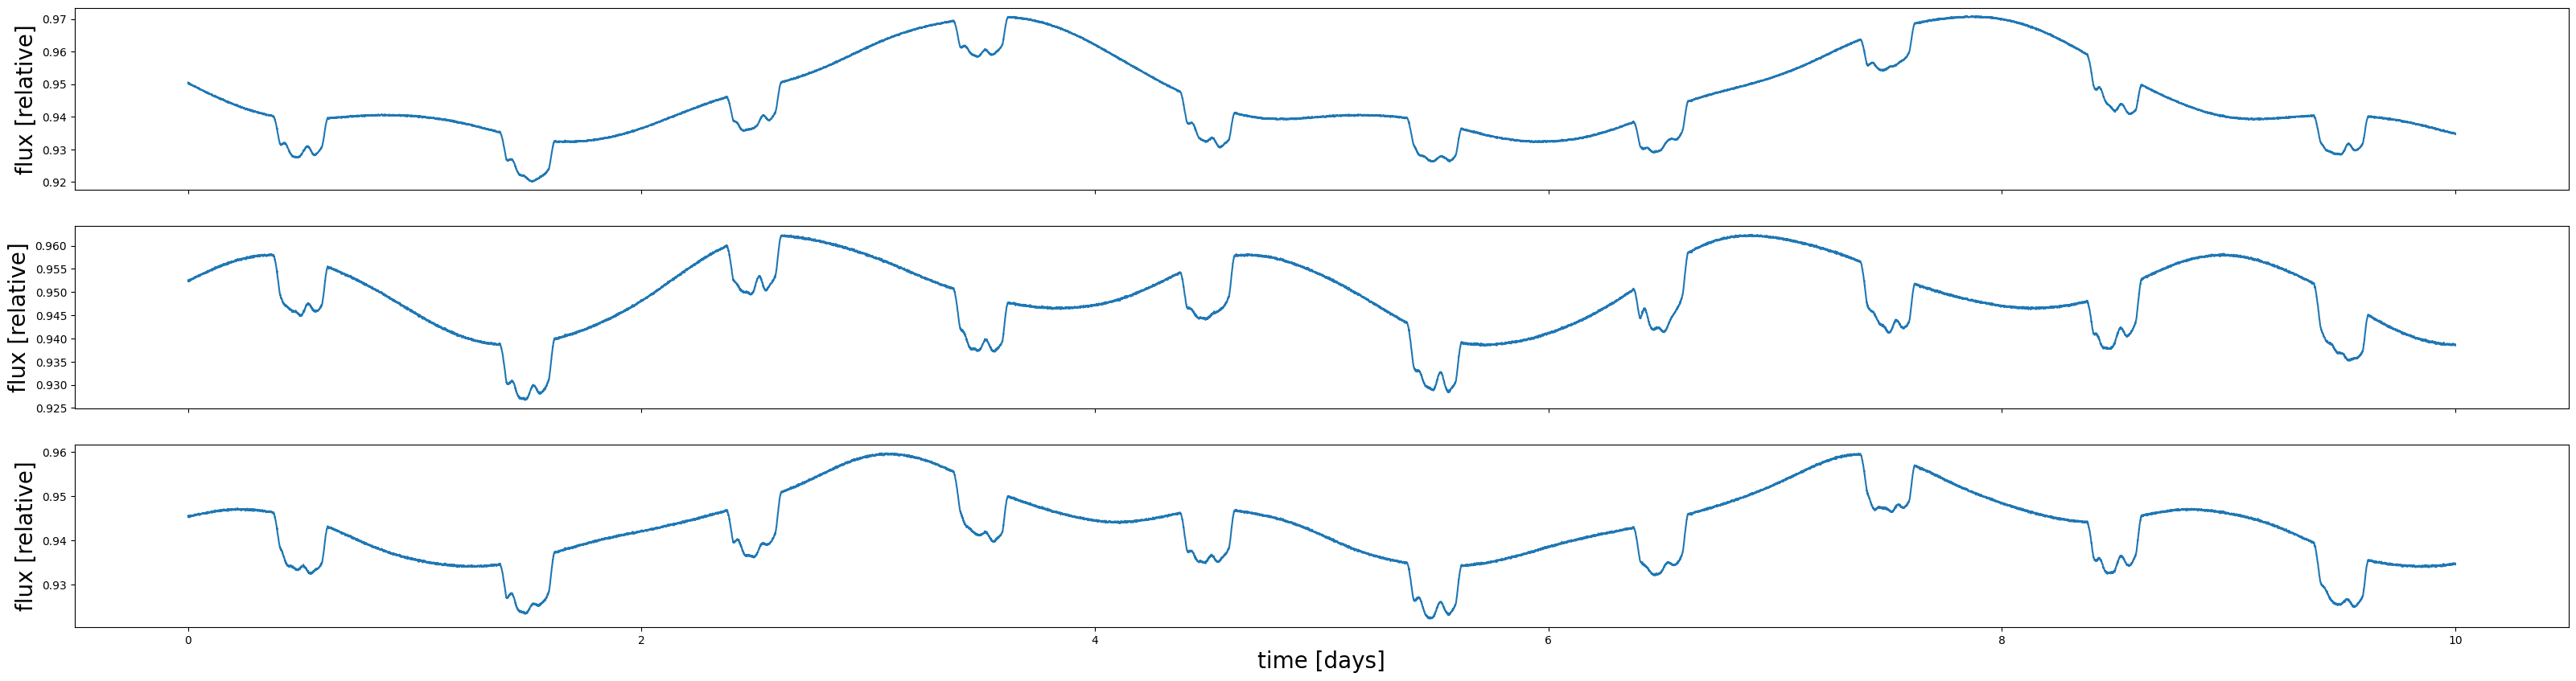

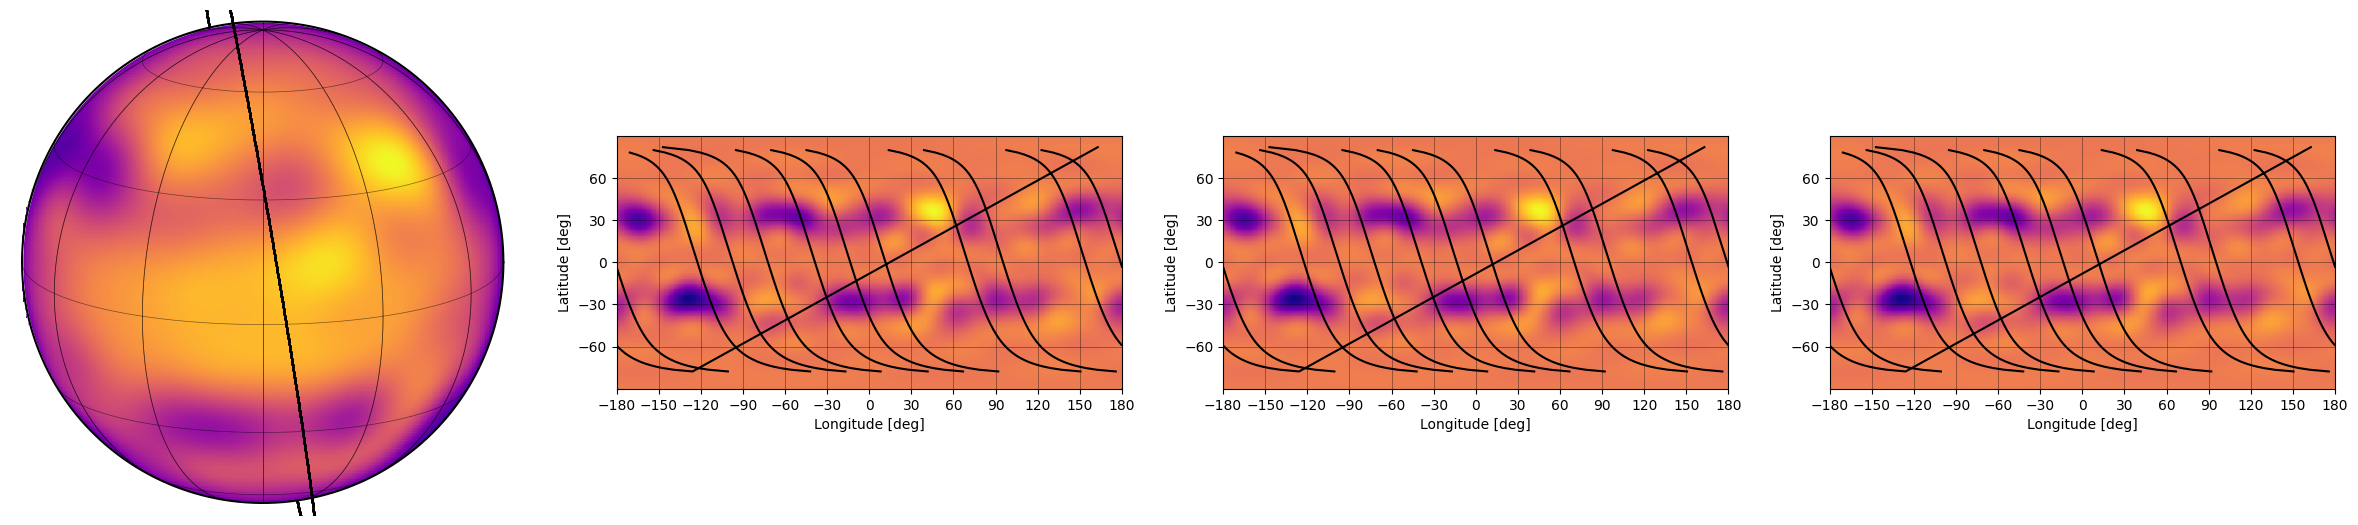

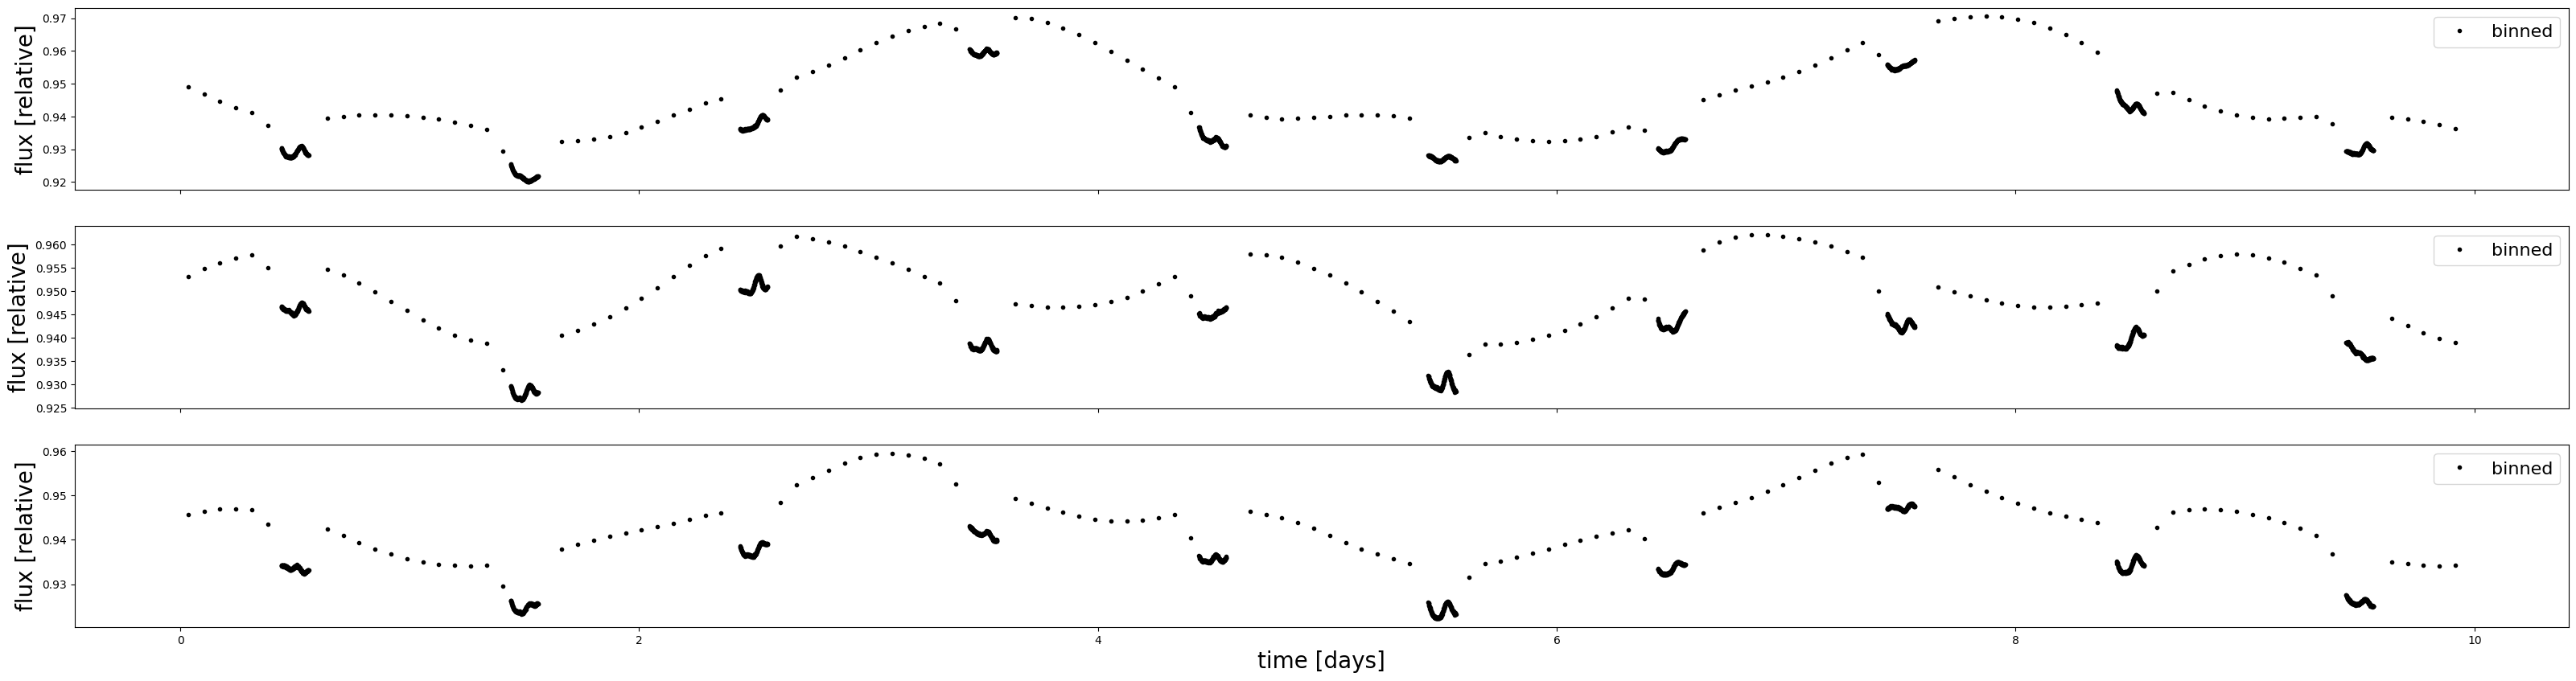

In [146]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Uniform, "args": [-180,180]},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 75, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 4.3, "dist": pm.Uniform, "args": [0.1, 5.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# Time array (10 days @ 1 min cadence)
t = np.arange(0, 10, 1 / 24 / 60)

# Get the light curve
flux, err, med_flux, mu_flux = generate(t, params, error=1e-4)

size=(3,1846)
t_ = np.zeros(size)
flux_ = np.zeros(size)
err_ = np.zeros(size)
# Get the binned light curve
for i in range(len(flux)):
    t_[i], flux_[i], err_[i] = bin_out_of_transit(t, flux[i], err[i], params, dt=0.06, binsize=100)

# Plot the data
fig, ax = plt.subplots(3, figsize=(40, 10), sharex=True)
for n in range(len(flux)):
    # ax[n].plot(t, flux[n], "C1.", alpha=1, label="full")
    ax[n].plot(t_[n], flux_[n], "k.", label="binned")
    ax[n].set_ylabel("flux [relative]", fontsize=20)
    ax[-1].set_xlabel("time [days]", fontsize=20)
    ax[n].legend(fontsize=16);


In [147]:
t_ = t_[0]

In [148]:
params['gp.norm']['truth'] = med_flux

# Inference

In [149]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True

p["planet.inc"]["free"] = True
p["planet.ecc"]["free"] = True
p["planet.porb"]["free"] = True
p["planet.t0"]["free"] = True
p["planet.r"]["free"] = True
p["planet.w"]["free"] = True
p["planet.Omega"]["free"] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t_, flux_, err_, p)

In [150]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [153]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

message: Desired error not necessarily achieved due to precision loss.
logp: -137035.17733953457 -> 13720.397230880928


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]

[ 8.18839203e+01  3.30652884e-01  1.05633573e+02 -3.62238821e-01
  9.99840753e-01  5.05497782e-01  9.92623654e-02  1.03196708e+01
  1.19609735e-01  2.97419448e+01  3.44095646e+01  7.03361049e+00
  9.73100721e-01]


In [154]:
nwalkers = 30
p0 = mci.get_initial_state(nwalkers)

In [155]:
mci.logp(x)

array(13720.18673766)

# Sampling
Will's sampling technique:

1. Run for nsteps = 100 steps; look at the $<lnprob>$ over the ensemble at each step; reset.
2. nsteps = 100; look at the autocorrelation estimate. 

In [37]:
import emcee

# Number of parameters
ndim = p0.shape[1]

# Instantiate the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)

# Run the chains
np.random.seed(0)
nsteps = 1000
# state = sampler.run_mcmc(p0, nsteps, progress=True, store=True)

In [37]:
max_n = 1000
n_inc = 1

# We'll track how the average autocorrelation time estimate changes
index = 0
ave_logp = np.empty(max_n)

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every n_inc steps
    if sampler.iteration % n_inc:
        continue
    
    L = sampler.get_log_prob()
    ave_logp[index] = np.mean(L)
    index += 1

100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it]


In [38]:
index

1000

Text(0, 0.5, 'mean logp')

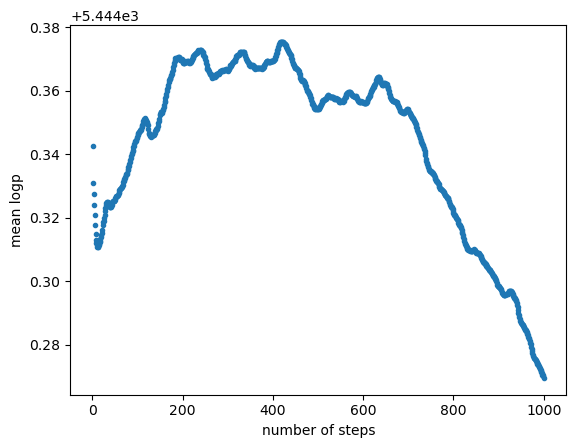

In [39]:
n = np.arange(1, index + 1)
y = ave_logp[:index]
plt.plot(n, y, '.')
plt.xlabel("number of steps")
plt.ylabel('mean logp')

In [28]:
import arviz as az
az.summary(sampler)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
var_0 -0.507  0.032  -0.566   -0.446      0.004    0.003      65.0     219.0   
var_1  0.579  0.782  -0.647    2.168      0.146    0.104      28.0      29.0   
var_2 -1.547  0.301  -2.037   -0.914      0.054    0.039      33.0      40.0   
var_3 -1.059  0.202  -1.459   -0.740      0.027    0.019      62.0     142.0   
var_4 -0.387  0.803  -1.854    1.112      0.111    0.079      50.0     144.0   
var_5 -0.560  0.097  -0.738   -0.379      0.012    0.009      59.0     307.0   

       r_hat  
var_0   1.17  
var_1   1.52  
var_2   1.39  
var_3   1.19  
var_4   1.23  
var_5   1.19

In [38]:
def run_sampler_to_convergence(sampler, xs, nsamp):
    while True:
        sampler.reset()
        sampler.run_mcmc(xs, int(round(nsamp/2)), progress=True)
        xs = sampler.chain[:,-1,:]
        mean_lnprobs = np.mean(sampler.lnprobability, axis=0)

        if mean_lnprobs[-1] < mean_lnprobs[0]:
            break

    # Burned in, at least in the likelihood
    nfac = 1
    while True:
        xs = sampler.chain[:,-1,:]
        sampler.reset()
        sampler.run_mcmc(xs, nsamp, progress=True, thin_by=nfac)

        ac = sampler.get_autocorr_time(quiet=True)

        ac = np.max(ac)

        Nact = nsamp / ac

        if Nact > 50:
            break
        nfac *= 2

    return sampler

In [39]:
sampler.reset()

In [40]:
nsteps=2000

In [41]:
sampler_new = run_sampler_to_convergence(sampler, p0, nsteps)

100%|██████████| 2000/2000 [2:17:05<00:00,  4.11s/it]  
The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [148.16237005 181.5214065  148.86272094 153.77744162 147.86838851
 150.65995277 145.314652   151.80823905 148.94694254 170.98373528
 154.27866245 169.85597873 133.29703168 157.34882537]
100%|██████████| 4000/4000 [4:34:07<00:00,  4.11s/it]  
The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [144.30865168 138.82402042 116.0103008  119.2792946  150.83438693
 109.81905426 133.98766507 126.56146134 114.58081578 129.9716739
 131.40623117 129.55289449 139.52304468 130.58598577]
100%|██████████| 8000/8000 [9:10:34<00:00,  4.13s/it]  
The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a lo

In [42]:
import arviz as az
az.summary(sampler_new)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
var_0   -5.627  1.333  -8.208   -3.046      0.090    0.064     187.0   
var_1    1.978  0.902   0.395    3.532      0.093    0.066      67.0   
var_2    4.508  1.236   2.468    6.855      0.058    0.041     360.0   
var_3   -1.674  0.128  -1.909   -1.439      0.008    0.006     265.0   
var_4    6.185  1.613   3.766    9.515      0.157    0.125     206.0   
var_5   -0.460  0.057  -0.552   -0.340      0.003    0.002     854.0   
var_6   -0.318  0.084  -0.447   -0.123      0.013    0.009      63.0   
var_7    0.403  0.278  -0.202    0.623      0.050    0.036      60.0   
var_8   -0.005  0.034  -0.031    0.072      0.006    0.004      60.0   
var_9   -1.490  0.548  -2.191   -0.237      0.090    0.064      52.0   
var_10   4.396  0.666   3.194    5.605      0.047    0.033     209.0   
var_11   1.803  0.117   1.655    1.886      0.020    0.015      70.0   
var_12   1.567  0.872  -0.299    2.126      0.158    0.113      60.0   
var_13  77.225  8.368  72.685   96.398      1.522    1.087      60.0   

        ess_tail  r_hat  
var_0      139.0   1.11  
var_1      109.0   1.37  
var_2      304.0   1.05  
var_3      200.0   1.08  
var_4       53.0   1.10  
var_5      103.0   1.12  
var_6      106.0   1.40  
var_7      111.0   1.43  
var_8       98.0   1.43  
var_9       46.0   1.55  
var_10    1987.0   1.09  
var_11      44.0   1.34  
var_12      81.0   1.42  
var_13      89.0   1.43

In [43]:
samples = sampler.chain.reshape(-1, ndim)

In [44]:
samples = mci.transform(samples, varnames=free)

100%|██████████| 60000/60000 [2:39:38<00:00,  6.26it/s]  


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


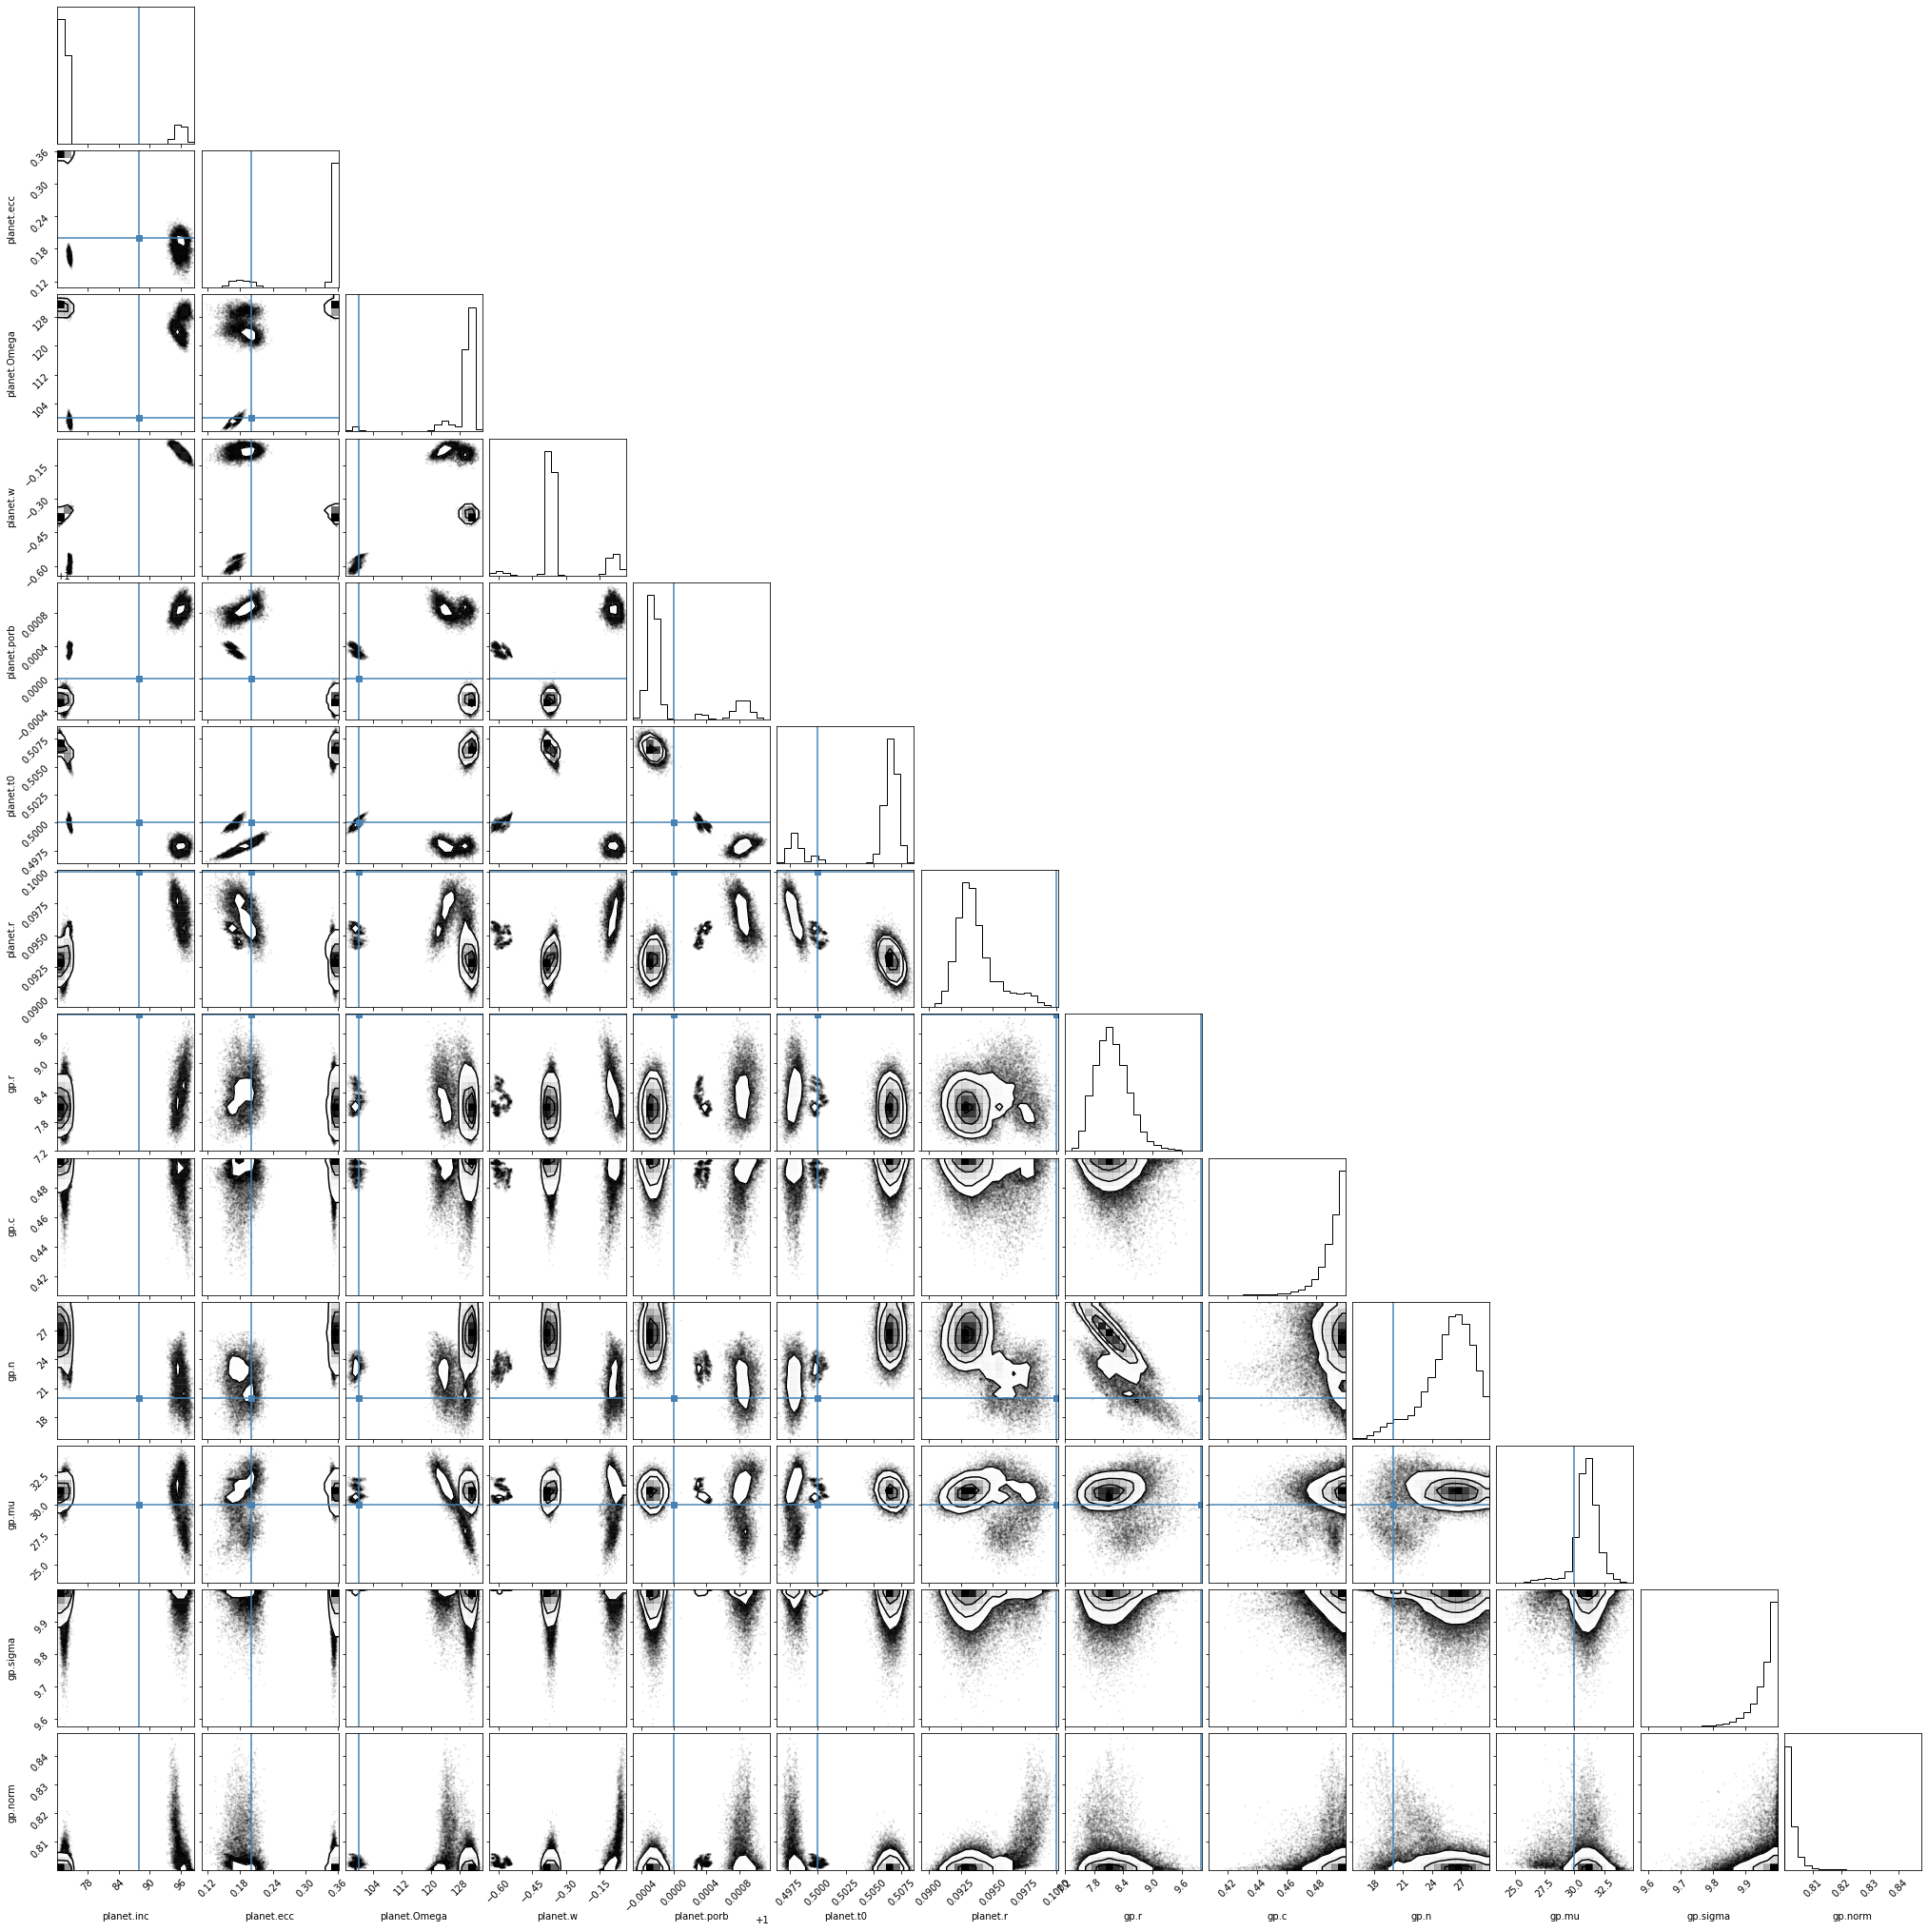

In [45]:
corner(np.array(samples), labels=free, truths=[params[x]["truth"] for x in free]);

In [66]:
samples.shape

(60000, 13)

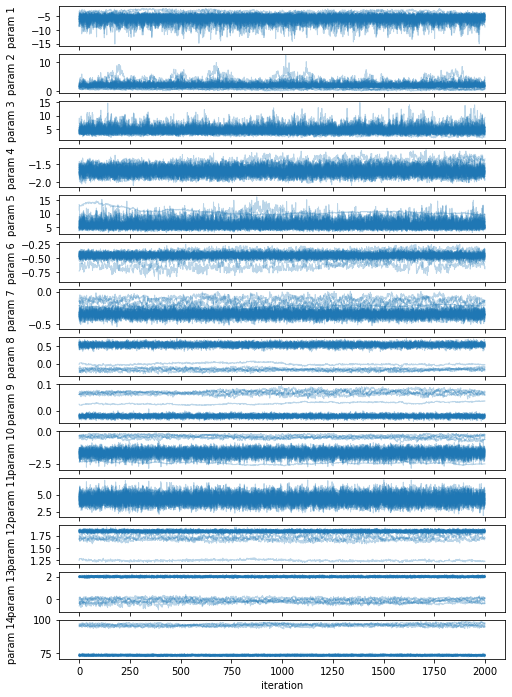

In [46]:
# Plot the walkers
fig, ax = plt.subplots(ndim, figsize=(8, 12), sharex=True)
for j in range(ndim):
    for k in range(nwalkers):
        ax[j].plot(sampler_new.chain[k, :, j], "C0-", lw=1, alpha=0.3)
    ax[j].set_ylabel("param {}".format(j + 1))
ax[-1].set_xlabel("iteration")
fig.align_ylabels(ax)
plt.show()

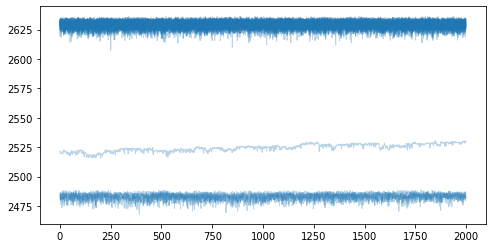

In [47]:
fig, ax = plt.subplots(1, figsize=(8, 4))
for k in range(nwalkers):
    plt.plot(sampler_new.lnprobability[k], "C0-", lw=1, alpha=0.3)

In [51]:
# az.from_pymc3(sampler_new);
az.to_netcdf(sampler_new,'longerlc_128000_gps.andplanets.nc');

In [52]:
az_trace = az.from_netcdf('longerlc_128000_gps.andplanets.nc')

array([[<AxesSubplot: title={'center': 'var_0'}>,
        <AxesSubplot: title={'center': 'var_0'}>],
       [<AxesSubplot: title={'center': 'var_1'}>,
        <AxesSubplot: title={'center': 'var_1'}>],
       [<AxesSubplot: title={'center': 'var_2'}>,
        <AxesSubplot: title={'center': 'var_2'}>],
       [<AxesSubplot: title={'center': 'var_3'}>,
        <AxesSubplot: title={'center': 'var_3'}>],
       [<AxesSubplot: title={'center': 'var_4'}>,
        <AxesSubplot: title={'center': 'var_4'}>],
       [<AxesSubplot: title={'center': 'var_5'}>,
        <AxesSubplot: title={'center': 'var_5'}>],
       [<AxesSubplot: title={'center': 'var_6'}>,
        <AxesSubplot: title={'center': 'var_6'}>],
       [<AxesSubplot: title={'center': 'var_7'}>,
        <AxesSubplot: title={'center': 'var_7'}>],
       [<AxesSubplot: title={'center': 'var_8'}>,
        <AxesSubplot: title={'center': 'var_8'}>],
       [<AxesSubplot: title={'center': 'var_9'}>,
        <AxesSubplot: title={'center': 'v

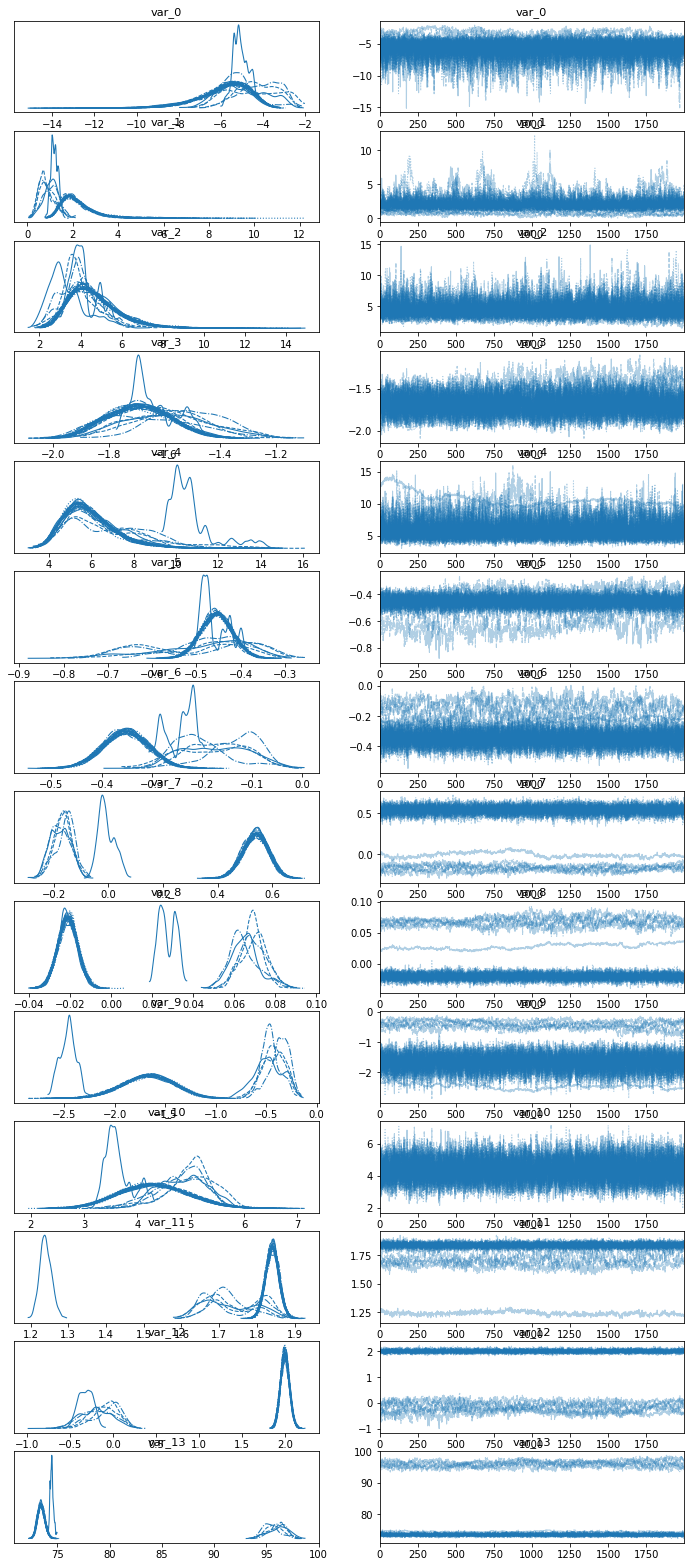

In [53]:
az.plot_trace(az_trace)

In [69]:
samples_fromfile = az_trace.to_dataframe()

In [71]:
samples_fromfile.columns

Index([                'chain',                  'draw',
        ('posterior', 'var_0'),  ('posterior', 'var_1'),
        ('posterior', 'var_2'),  ('posterior', 'var_3'),
        ('posterior', 'var_4'),  ('posterior', 'var_5'),
        ('posterior', 'var_6'),  ('posterior', 'var_7'),
        ('posterior', 'var_8'),  ('posterior', 'var_9'),
       ('posterior', 'var_10'), ('posterior', 'var_11'),
       ('posterior', 'var_12'), ('posterior', 'var_13'),
        ('sample_stats', 'lp')],
      dtype='object')

In [72]:
samples_fromfile = samples_fromfile.iloc[:, 2:15]

In [73]:
samples_fromfile = samples_fromfile.iloc[:,:-1]

In [88]:
samples_fromfile = mci.transform(samples_fromfile, varnames=free)

100%|██████████| 15000/15000 [10:30<00:00, 23.80it/s]


Too few points to create valid contours


ValueError: Provided figure has 144 axes, but data has dimensions K=13

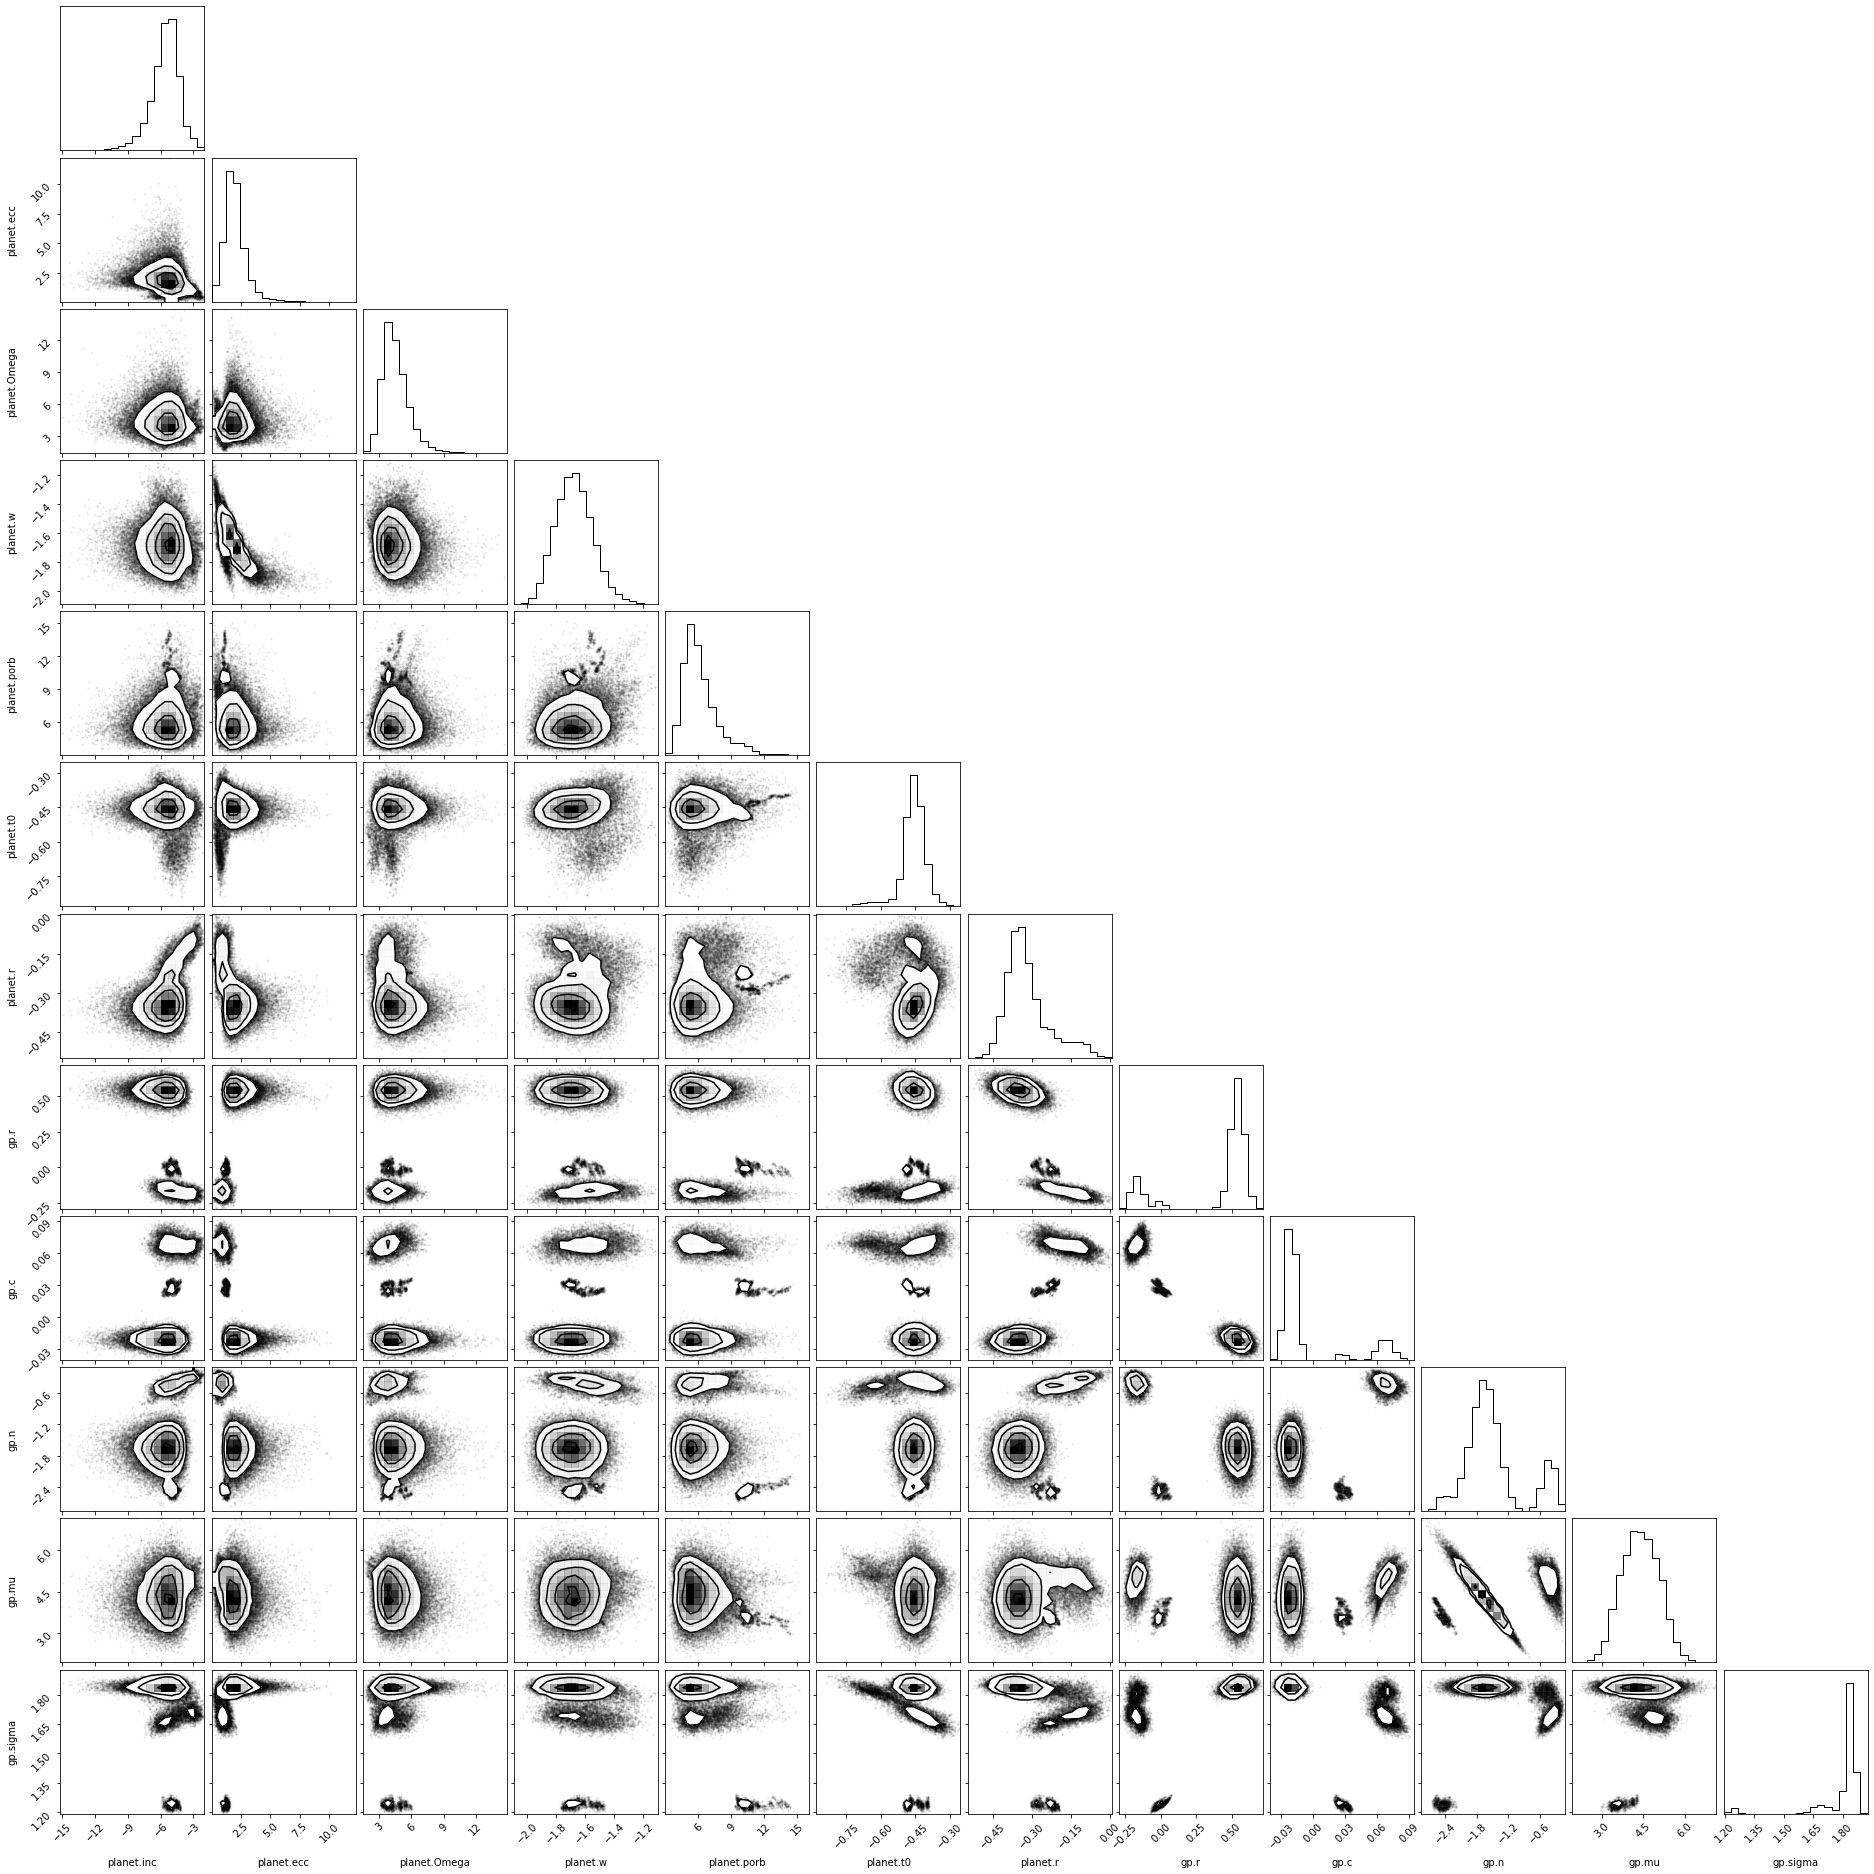

In [74]:
corner(np.array(samples_fromfile), labels=free, truths=[params[x]["truth"] for x in free]);

# NUTS

In [10]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]



gp.r: 10.613900576186456 [10]
gp.c: 0.08687329302488711 [0.1]
gp.n: 18.696842593820957 [20]
gp.mu: 28.399493413383183 [30]
gp.sigma: 3.4169558442122416 [5]
gp.norm: 0.9498009263124332 [0.9465644356990636]


message: Desired error not necessarily achieved due to precision loss.
logp: 5446.105103442844 -> 5448.432825955446


In [11]:
with model:
    trace = pmx.sample(
        tune=500,
        draws=1000,
        init='adapt_full',
        start=map_soln,
        chains=4,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 187016 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8115907107209662, but should be close to 0.9. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


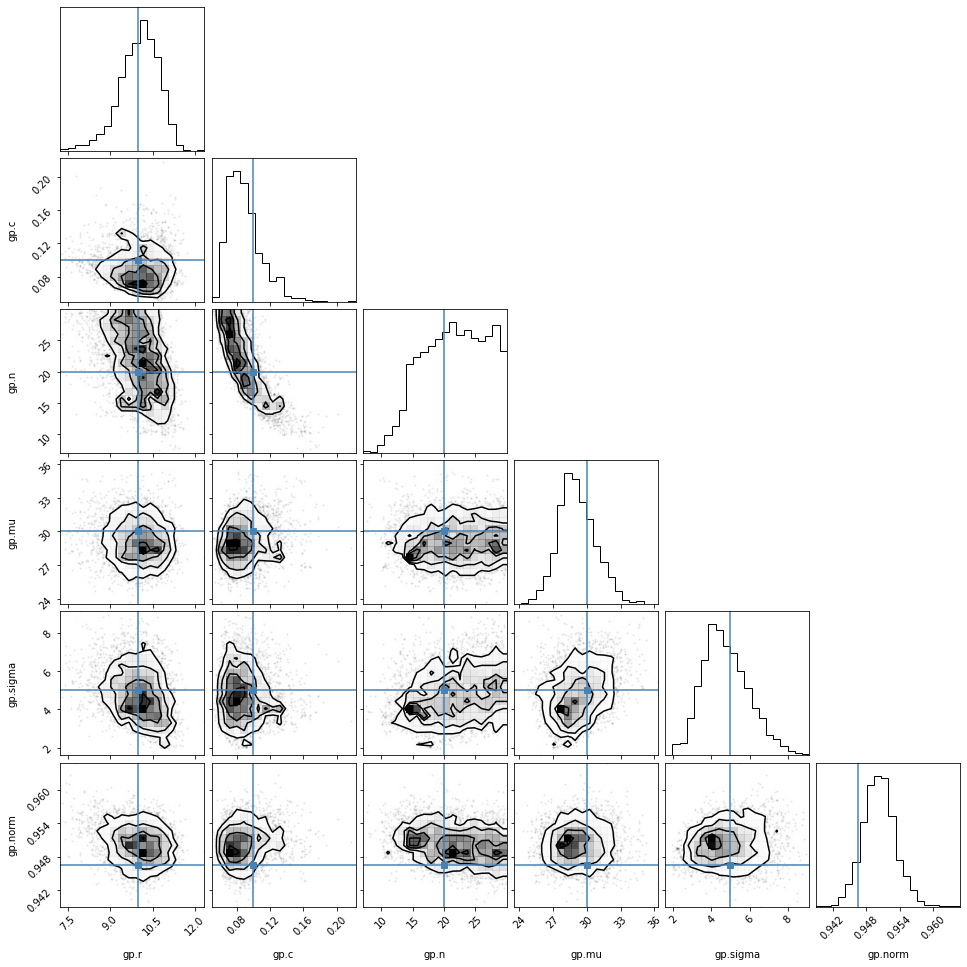

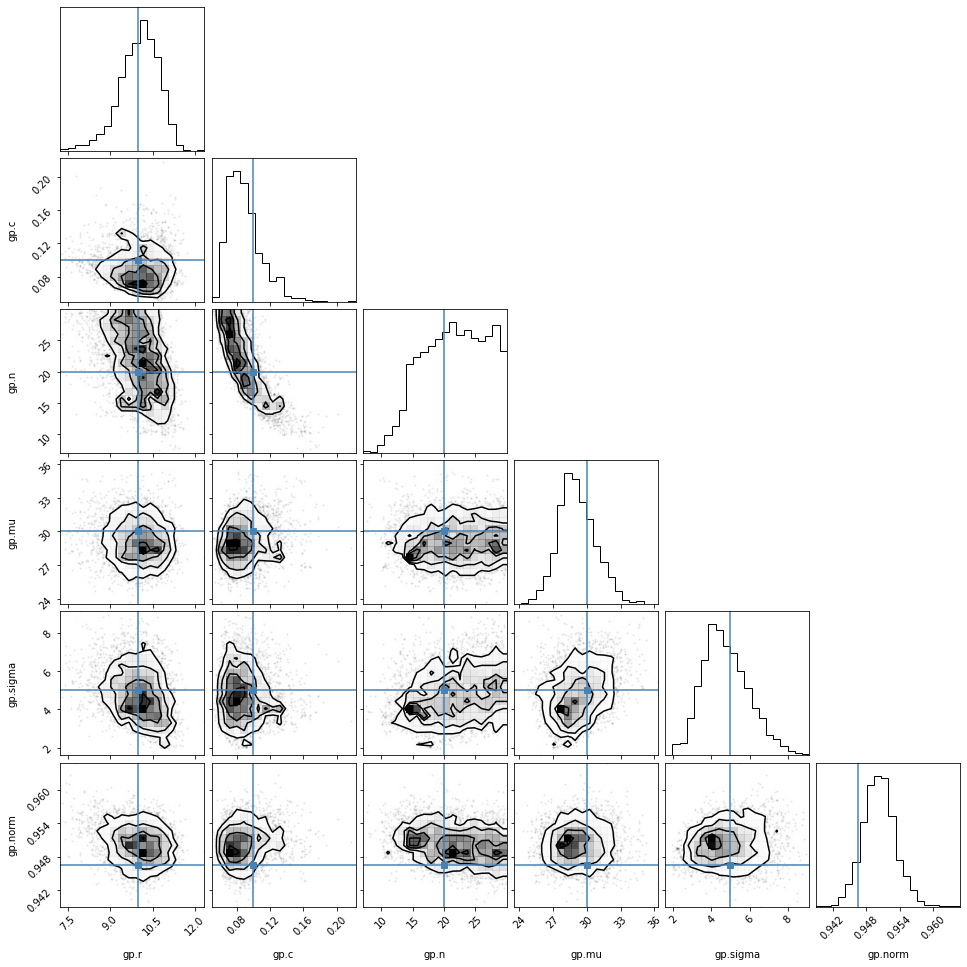

In [12]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free])

Got error No model on context stack. trying to find log_likelihood in translation.
/home/ssagynbayeva/.conda/envs/starry/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'gp.r'}>,
        <AxesSubplot: title={'center': 'gp.r'}>],
       [<AxesSubplot: title={'center': 'gp.c'}>,
        <AxesSubplot: title={'center': 'gp.c'}>],
       [<AxesSubplot: title={'center': 'gp.n'}>,
        <AxesSubplot: title={'center': 'gp.n'}>],
       [<AxesSubplot: title={'center': 'gp.mu'}>,
        <AxesSubplot: title={'center': 'gp.mu'}>],
       [<AxesSubplot: title={'center': 'gp.sigma'}>,
        <AxesSubplot: title={'center': 'gp.sigma'}>],
       [<AxesSubplot: title={'center': 'gp.norm'}>,
        <AxesSubplot: title={'center': 'gp.norm'}>]], dtype=object)

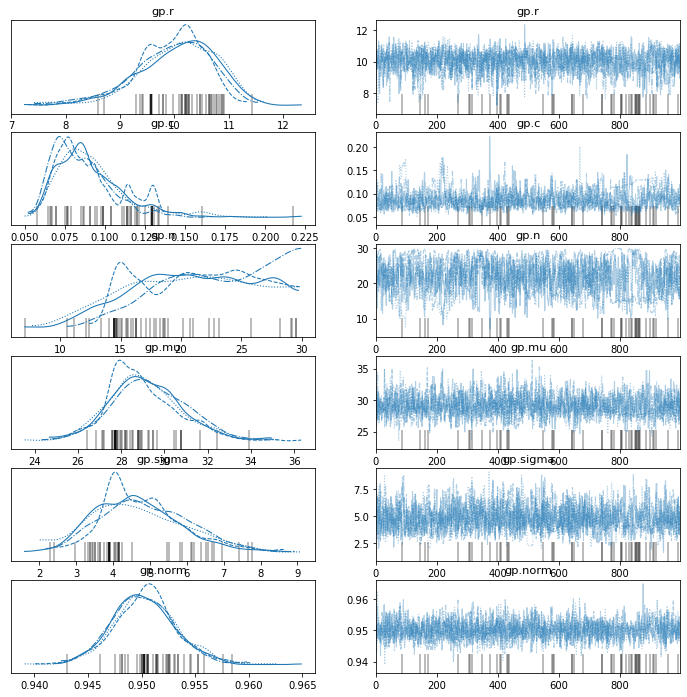

In [13]:
import arviz as az
az.plot_trace(trace,var_names=free)

In [29]:
az.from_pymc3(trace)
az.to_netcdf(trace,'gp_params_NUTS_tune500_1000draws.nc')

Got error No model on context stack. trying to find log_likelihood in translation.
/home/ssagynbayeva/.conda/envs/starry/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


'gp_params_NUTS_tune500_1000draws.nc'

In [31]:
az_trace = az.from_netcdf('gp_params_NUTS_tune500_1000draws.nc')

array([[<AxesSubplot: title={'center': 'gp.r'}>,
        <AxesSubplot: title={'center': 'gp.r'}>],
       [<AxesSubplot: title={'center': 'gp.c'}>,
        <AxesSubplot: title={'center': 'gp.c'}>],
       [<AxesSubplot: title={'center': 'gp.n'}>,
        <AxesSubplot: title={'center': 'gp.n'}>],
       [<AxesSubplot: title={'center': 'gp.mu'}>,
        <AxesSubplot: title={'center': 'gp.mu'}>],
       [<AxesSubplot: title={'center': 'gp.sigma'}>,
        <AxesSubplot: title={'center': 'gp.sigma'}>],
       [<AxesSubplot: title={'center': 'gp.norm'}>,
        <AxesSubplot: title={'center': 'gp.norm'}>]], dtype=object)

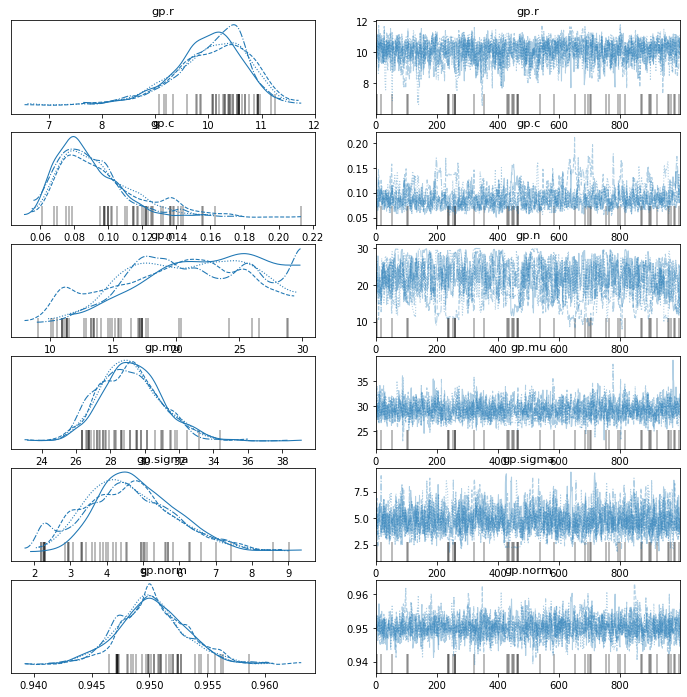

In [32]:
az.plot_trace(az_trace,var_names=free)